## Imports and loading data

In [1]:
%pip install tensorflow_datasets
%pip install pickle



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np

2024-11-21 14:20:08.422945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:20:11.222022: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-21 14:20:11.222125: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-21 14:20:11.251339: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-11-21 14:20:16.282641: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.


In [3]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True,  # Include labels
    # shuffle_files=False,
    # with_info=True
)


2024-11-21 14:20:22.094634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:20:22.095263: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA T400 4GB)
2024-11-21 14:20:22.213609: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) Iris(R) Xe Graphics)
2024-11-21 14:20:22.262885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 14:20:22.262909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Yo

In [5]:
# ds, ds_info = tfds.load('tf_flowers', split='train',shuffle_files=True, with_info=True)
# fig = tfds.show_examples(ds, ds_info)


In [6]:
train_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [7]:
train_ds.shape, train_labels.shape

(TensorShape([2569, 442, 1024, 3]), TensorShape([2569]))

## Preprocessing data

In [8]:
size = (150, 150)

train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))


In [9]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

In [10]:

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [11]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [12]:
train_ds.shape

TensorShape([2569, 150, 150, 3])

## Loading VGG16 model

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

base_model = VGG16(
    weights="imagenet", include_top=False, 
    input_shape=train_ds[0].shape
)

base_model.trainable = False


In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Adding Layers

In [15]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,   # vgg16 here
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 50)                409650    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,125,463
Trainable params: 410,775
Non-trainable params: 14,714,688
_________________________________________________________________


## Training model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', patience=5,  
    restore_best_weights=True
)

history = model.fit(
    train_ds, train_labels, 
    epochs=50, 
    validation_split=0.2, 
    batch_size=32, 
    callbacks=[es]
)

model.save('model.h5')


Epoch 1/50


2024-11-21 14:20:30.415254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 14:20:30.492233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 14:20:30.492269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 14:20:30.492297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 14:20:30.492310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

65/65 [==============================] - ETA: 0s - loss: 1.8134 - accuracy: 0.3747

2024-11-21 14:21:05.991492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 14:21:06.052061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 14:21:06.052104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 14:21:06.052134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 14:21:06.052150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

65/65 [==============================] - 44s 653ms/step - loss: 1.8134 - accuracy: 0.3747 - val_loss: 1.3090 - val_accuracy: 0.4514
Epoch 2/50
65/65 [==============================] - 42s 641ms/step - loss: 1.0882 - accuracy: 0.5888 - val_loss: 1.3194 - val_accuracy: 0.5506
Epoch 3/50
65/65 [==============================] - 42s 647ms/step - loss: 0.7848 - accuracy: 0.7173 - val_loss: 1.2479 - val_accuracy: 0.6556
Epoch 4/50
65/65 [==============================] - 46s 707ms/step - loss: 0.5737 - accuracy: 0.7922 - val_loss: 1.1809 - val_accuracy: 0.6537
Epoch 5/50
65/65 [==============================] - 43s 665ms/step - loss: 0.4422 - accuracy: 0.8380 - val_loss: 1.0648 - val_accuracy: 0.6809
Epoch 6/50
65/65 [==============================] - 43s 658ms/step - loss: 0.3106 - accuracy: 0.8847 - val_loss: 1.1437 - val_accuracy: 0.6770
Epoch 7/50
65/65 [==============================] - 43s 663ms/step - loss: 0.2506 - accuracy: 0.9100 - val_loss: 1.2150 - val_accuracy: 0.6654
Epoch 8/50

KeyboardInterrupt: 

In [ ]:

import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
model.evaluate(test_ds, test_labels)

2024-11-21 13:15:41.788418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 13:15:41.850156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 13:15:41.850201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 13:15:41.850231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 13:15:41.850244: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

35/35 [==============================] - 20s 558ms/step - loss: 0.0824 - accuracy: 0.9791


[0.08237020671367645, 0.9791098833084106]

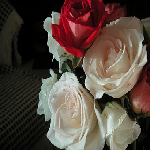

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/daisy/5794835_d15905c7c8_n.jpg"
sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/google_image_classification_example/img_dataset/flower_photos/roses/102501987_3cdb8e5394_n.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(150, 150)
)

img

In [ ]:
import keras.utils as image

#convert image to array
input_img = image.img_to_array(img)
input_img = np.expand_dims(input_img, axis=0)
# input_img

#Predict the inputs on the model
predict_img = model.predict(input_img )



1/1 [==============================] - 0s 15ms/step


In [ ]:
data = np.array([['dandelion','daisy','tulips','sunflowers','roses'],predict_img[0]])

import pandas as pd

df = pd.DataFrame(data[1:], columns=data[0])

# Display the DataFrame as a table
df

,dandelion,daisy,tulips,sunflowers,roses
0,1.1925752e-05,0.00059725635,0.06640492,0.6859498,0.24703616
